In [22]:
import seaborn as sns                                                                                    
import pandas as pd
import matplotlib.pyplot as plt
import argparse

%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

exp_base_folder = '/home/maxdml/datacenter-OS/src/python/plot_utils/data/'

In [115]:
def read_csv(csvfile, reset_time=True, second_ts=True, prune=True):
    df = pd.read_csv(csvfile, delimiter='\t').sort_values('TIME')
    if reset_time:
        df.TIME -= min(df.TIME)
    if second_ts:
        df.TIME /= 1e9
    if prune:
        value_df = df.loc[:, df.columns == 'VALUE']
        high = int(value_df.quantile(q=.9999))
        value_df = value_df.apply(lambda x: x[x < high])
        df = pd.concat([df.loc[:, 'TIME'], value_df], axis=1)
        df.dropna(inplace=True)
    return df

<IPython.core.display.Javascript object>


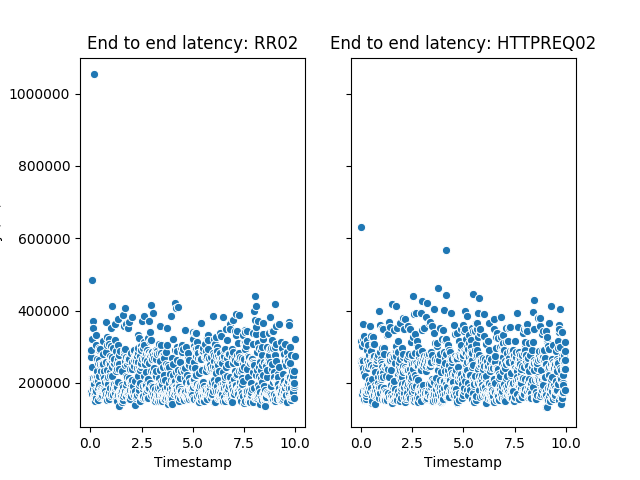

<IPython.core.display.Javascript object>


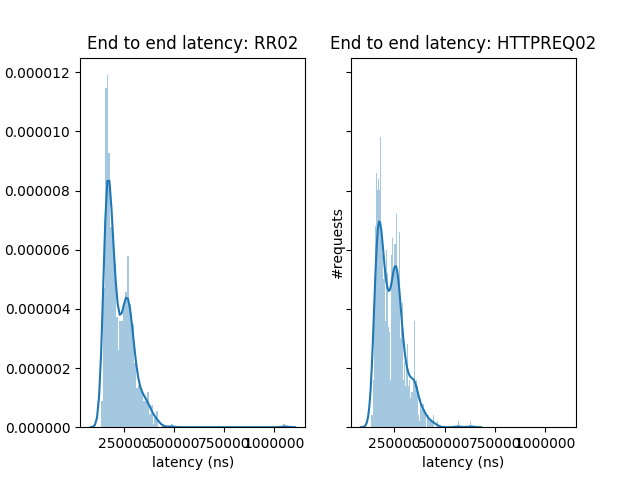

<IPython.core.display.Javascript object>


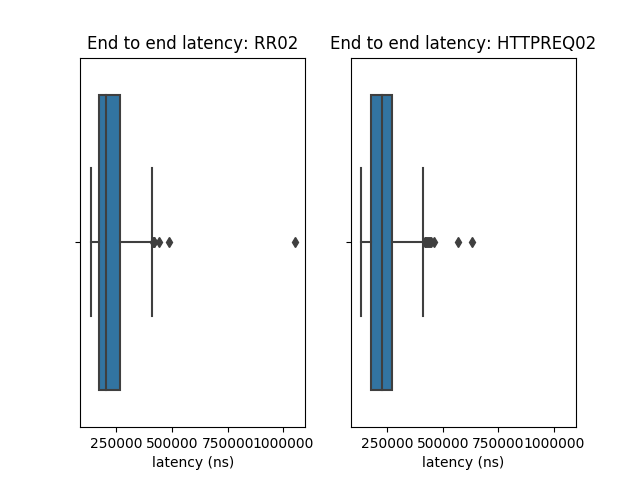

<IPython.core.display.Javascript object>


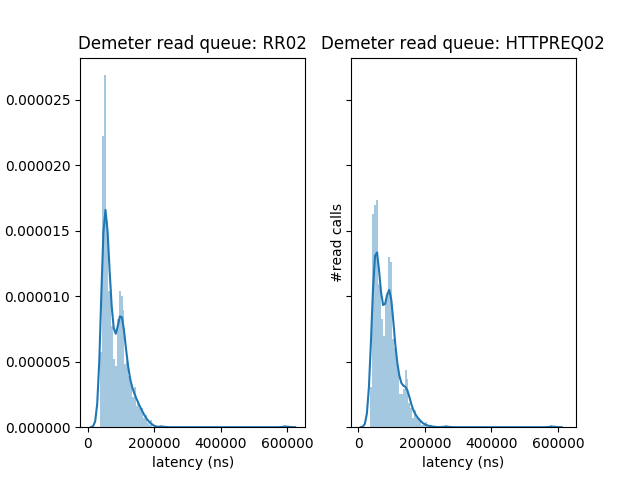

<IPython.core.display.Javascript object>


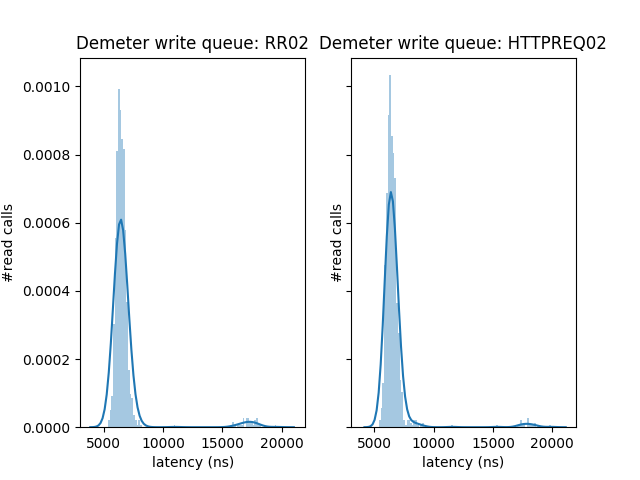

<IPython.core.display.Javascript object>


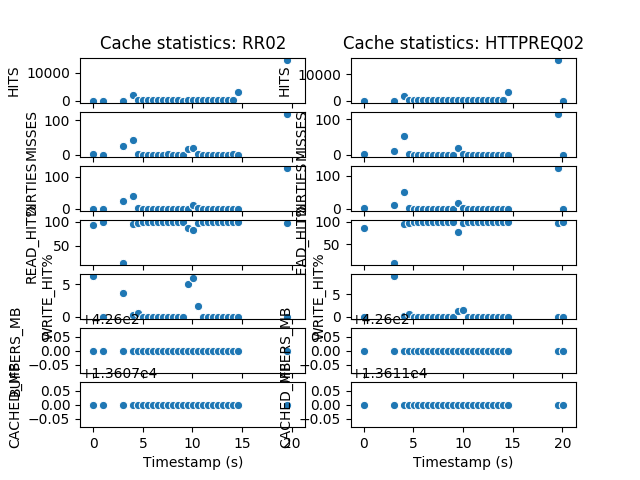

In [273]:
exps = ['RR02', 'HTTPREQ02']
setups = {}
for exp in exps:
    setups[exp] = {}
    exp_folder = exp_base_folder + exp + '/'
    e2e_filename = exp_folder + 'rate_client/' + exp + '_end-to-end'
    setups[exp]['e2e'] = read_csv(e2e_filename)
    
    dmtr_readq_filename = exp_folder + 'rate_client/' + 'queue-1-read-latencies'
    setups[exp]['dmtr_readq'] = pd.read_csv(dmtr_readq_filename)
    
    dmtr_writeq_filename = exp_folder + 'rate_client/' + 'queue-1-write-latencies'
    setups[exp]['dmtr_writeq'] = pd.read_csv(dmtr_writeq_filename)
    
    cachestats_filename = exp_folder + 'cachestat/cachestats.csv'
    df = pd.read_csv(cachestats_filename, delimiter='\t')
    df.dropna(inplace=True)
    df['WRITE_HIT%'] = df['WRITE_HIT%'].apply(lambda x: float(x.strip('%')))
    df['READ_HIT%'] = df['READ_HIT%'].apply(lambda x: float(x.strip('%')))
    df = df[(df.HITS > 0) | (df.MISSES > 0) | (df.DIRTIES > 0) | (df['READ_HIT%'] > 0) | (df['WRITE_HIT%'] > 0)]
    setups[exp]['cachestats'] =  df
    setups[exp]['cachestats'].TIME -= min(setups[exp]['cachestats'].TIME)

###### End to end latencies
fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True)
for i, setup in enumerate(setups.keys()):
    sns.scatterplot(x = setups[setup]['e2e'].TIME, y='VALUE', data=setups[setup]['e2e'], palette='colorblind', ax=axs[0][i])
    axs[0][i].set(xlabel='Timestamp', ylabel='latency (ns)')
    axs[0][i].set_title('End to end latency: {}'.format(setup))

fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True, sharex=True)
for i, setup in enumerate(setups.keys()):
    sns.distplot(setups[setup]['e2e'].VALUE, bins=100, ax=axs[0][i])
    axs[0][i].set(xlabel='latency (ns)', ylabel='#requests')
    axs[0][i].set_title('End to end latency: {}'.format(setup))
    
fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True, sharex=True)
for i, setup in enumerate(setups.keys()):
    sns.boxplot(x=setups[setup]['e2e'].VALUE, ax=axs[0][i])
    axs[0][i].set(xlabel='latency (ns)')
    axs[0][i].set_title('End to end latency: {}'.format(setup))
    
    
###### Demeter queue numbers
fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True, sharex=True)
for i, setup in enumerate(setups.keys()):
    sns.distplot(setups[setup]['dmtr_readq'].VALUE, bins=100, ax=axs[0][i])
    axs[0][i].set(xlabel='latency (ns)', ylabel='#read calls')
    axs[0][i].set_title('Demeter read queue: {}'.format(setup))

fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True, sharex=True)
for i, setup in enumerate(setups.keys()):
    sns.distplot(setups[setup]['dmtr_writeq'].VALUE, bins=100, ax=axs[0][i])
    axs[0][i].set(xlabel='latency (ns)', ylabel='#read calls')
    axs[0][i].set_title('Demeter write queue: {}'.format(setup))
    
###### Cachestat numbers
cols = setups[setup]['cachestats'].drop('TIME', axis=1).columns
fig, axs = plt.subplots(len(cols), len(exps), squeeze=False, sharex=True)
for i, setup in enumerate(setups.keys()):
    for j, col in enumerate(cols):
        sns.scatterplot(x = setups[setup]['cachestats'].TIME, y=col, data=setups[setup]['cachestats'], palette='colorblind', ax=axs[j][i])
        axs[j][i].set(xlabel='Timestamp (s)', ylabel='{}'.format(col))
    axs[0][i].set_title('Cache statistics: {}'.format(setup))